In [221]:
import torch 
import torch.nn as nn
from  torch.functional import F
from torch.utils.data import DataLoader, Dataset
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
# from fastai import *
# from fastai.utils import *

In [2]:
class GeneralReLU(nn.Module):
 		"""docstring for GeneralReLU"""
 		def __init__(self, leak=None, sub=None, maxv=None):
 			super(GeneralReLU, self).__init__()
 			self.leak, self.sub, self.maxv = leak, sub, maxv
 		
 		def forward(self, x):
 			x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
 			if self.sub is not None: x.sub_(self.sub)
 			if self.maxv is not None: x.clamp_max_(self.maxv)
 			return x

def conv_layer(ni, nf, ks, stride=1, padding=None, leak=None, sub=None, maxv=None, bn=False, dp=None, **kwargs):
	padding = padding or ks//2
	conv = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding)
	layers = [conv]
	if bn is not None: layers.append(nn.BatchNorm2d(nf))
	if dp is not None: layers.append(nn.Dropout(dp))
	relu = GeneralReLU(leak, sub, maxv)
	layers.append(relu)
	return nn.Sequential(*layers)

def linear_layer(ni, no, leak=None, sub=None, maxv=None, **kwargs):
	return nn.Sequential(nn.Linear(ni, no), 
						 GeneralReLU(leak, sub, maxv))

In [3]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=1, **kwargs):
        "Output will be 2*sz or 2 if sz is None"
        super(AdaptiveConcatPool2d, self).__init__()
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [4]:
class CNNModel(nn.Module):
    """docstring for EyeMosel"""
    def __init__(self, params=[], **kwargs):
        super(CNNModel, self).__init__()
        self.params = params
        self.layers = [conv_layer(*param, **kwargs) for param in  self.params]
        self.features = nn.Sequential(*self.layers)
        self.pool = AdaptiveConcatPool2d(**kwargs)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.flatten(x)
#         x = x.view(x.size(0), -1)
        return x

In [75]:
params = \
[
    [3, 64, 7, 2],
    [64, 128, 3],
    [128, 256, 3, 2],
    [256, 512, 3, 2],
    [512, 256, 1, 2],#?
    [1024, 256]
]

In [96]:
class EyeModel(nn.Module):
    """docstring for EyeMosel"""
    def __init__(self, params=[[]], **kwargs):
        super(EyeModel, self).__init__()
        self.params = params
        self.cnn = CNNModel(self.params[:-1], **kwargs)
        self.fc = linear_layer(*params[-1], **kwargs)
    def forward(self, xl, xr):
        xl = self.cnn(xl)
        xr = self.cnn(xr)
        x = torch.cat((xl, xr), 1)
        x = self.fc(x)
        return x

In [97]:
eye = EyeModel(params)

In [98]:
x = torch.randn([8, 3, 56, 56])
eye(x, x).size()

torch.Size([8, 256])

In [99]:
params = \
[
    [1, 64, 3, 2],
    [64, 128, 3],
    [256, 64]
]

In [100]:
class FaceGridModel(nn.Module):
    # Model for the face grid pathway
    def __init__(self, params=[[]], **kwargs):
        super(FaceGridModel, self).__init__()
        self.params = params
        self.cnn = CNNModel(self.params[:-1], **kwargs)
        self.fc = linear_layer(*params[-1], **kwargs)

    def forward(self, x):

        x = self.cnn(x)
        x = self.fc(x)
        return x

In [102]:
face_grid = FaceGridModel(params)
# face_grid

In [103]:
x = torch.randn([8, 1, 25, 25])
x.size()

torch.Size([8, 1, 25, 25])

In [104]:
face_grid(x).size()

torch.Size([8, 64])

In [114]:
params = \
[
    [3, 64, 7, 2],
    [64, 128, 3],
    [128, 256, 3, 2],
    [256, 512, 3, 2],
    [512, 256, 1, 2],#?
    [512, 256]
]

In [116]:
class FaceModel(nn.Module):
	"""docstring for FaceModel"""
	def __init__(self, params=[[]], **kwargs):
		super(FaceModel, self).__init__()
		self.params = params
		self.cnn = CNNModel(self.params[:-1], **kwargs)
		self.fc = linear_layer(*params[-1], **kwargs)
	def forward(self, x):
		x = self.cnn(x)
		x = self.fc(x)
		return x

In [117]:
face = FaceModel(params)

In [118]:
x = torch.randn([8, 3, 56, 56])
x.size()

torch.Size([8, 3, 56, 56])

In [119]:
face(x).size()

torch.Size([8, 256])

In [129]:
eye_params = \
[
    [3, 64, 7, 2],
    [64, 128, 3],
    [128, 256, 3, 2],
    [256, 512, 3, 2],
    [512, 256, 1, 2],#?
    [1024, 256]
]
face_params = \
[
    [3, 64, 7, 2],
    [64, 128, 3],
    [128, 256, 3, 2],
    [256, 512, 3, 2],
    [512, 256, 1, 2],#?
    [512, 256]
]

face_grid_params = \
[
    [1, 64, 3, 2],
    [64, 128, 3],
    [256, 64]
]

In [170]:
class StaticModel(nn.Module):
	"""docstring for EncoderCNN"""
	def __init__(self, eye_params=[[]], face_params=[[]], face_grid_params=[[]], pretrained=False):
		super(StaticModel, self).__init__()
		self.eye_params = eye_params
		self.face_params = face_params
		self.face_grid_params = face_grid_params

		self.eye_model = EyeModel(self.eye_params)
		self.face_model = FaceModel(self.face_params)
		self.face_grid_model = FaceGridModel(self.face_grid_params)

		self.fc1 = linear_layer(256+64, 128)
		self.fc2 = linear_layer(256+128, 128)
		self.out = nn.Linear(128, 2)

	def forward(self, xf, xl, xr, xg):
		# eyes
		xe = self.eye_model(xl, xr)#256
		#face and  grid
		xf = self.face_model(xf)#256
		xg = self.face_grid_model(xg)#64
		xf = torch.cat((xf, xg), 1)
		xf = self.fc1(xf)#128

		x = torch.cat((xe, xf), 1)
		x = self.fc2(x)#128
		x = self.out(x)

		return x

In [218]:
model = StaticModel(eye_params, face_params, face_grid_params)
model

StaticModel(
  (eye_model): EyeModel(
    (cnn): CNNModel(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralReLU()
        )
        (2): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralReLU()
        )
        (3): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

# Dataset

In [227]:
class DataRandom(Dataset):
    def __init__(self, imSize=[56, 56], gridSize=[25, 25]):
        self.imSize = imSize
        self.gridSize = gridSize
    def __getitem__(self, index):
        imFace = torch.randn([3] + self.imSize)
        imGrid = torch.randn([1] + self.gridSize)
        imEye = torch.randn([3] + self.imSize)
        y = torch.randn(2)
        x = (imFace, imEye, imEye, imGrid)
        return x, y
    def __len__(self):
        return 5*8

In [228]:
dataset = DataRandom()

In [229]:
bs = 8
dataloader = DataLoader(dataset, bs)

In [230]:
db = DataBunch(dataloader, dataloader, test_dl=dataloader)

In [231]:
learn = Learner(db, model, loss_func=mean_squared_error)

In [235]:
learn.lr_find(num_it=50)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


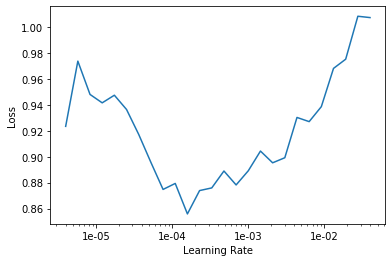

In [236]:
learn.recorder.plot()

In [238]:
cbs = [SaveModelCallback(learn, every="epoch", name='checkpoint')]

In [239]:
learn.fit_one_cycle(1, 1e-5, callbacks=cbs)

epoch,train_loss,valid_loss,time
0,0.994409,1.291697,00:07


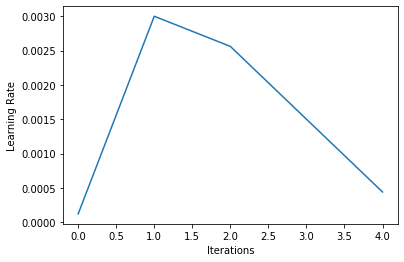

In [183]:
learn.recorder.plot_losses()

In [213]:
for p in model.named_parameters():
    print(p[1][0][0])
    break

tensor([[ 0.0092, -0.0015, -0.0487, -0.0411, -0.0519,  0.0780, -0.0314],
        [-0.0622,  0.0587,  0.0064, -0.0037, -0.0777,  0.0210, -0.0528],
        [-0.0043, -0.0721, -0.0358, -0.0681,  0.0027,  0.0508,  0.0759],
        [-0.0763, -0.0626, -0.0586,  0.0140, -0.0549, -0.0160, -0.0411],
        [ 0.0785,  0.0021, -0.0369,  0.0103,  0.0058, -0.0612, -0.0479],
        [-0.0119, -0.0072, -0.0497, -0.0679, -0.0257, -0.0359, -0.0521],
        [ 0.0144, -0.0129,  0.0421,  0.0687, -0.0158, -0.0243,  0.0110]],
       grad_fn=<SelectBackward>)


Sequential(
  (0): Linear(in_features=384, out_features=128, bias=True)
  (1): GeneralReLU()
)

In [214]:
m = nn.Sequential(*list(model.children()))

In [215]:
for p in m.named_parameters():
    print(p[1][0][0])
    break

tensor([[ 0.0092, -0.0015, -0.0487, -0.0411, -0.0519,  0.0780, -0.0314],
        [-0.0622,  0.0587,  0.0064, -0.0037, -0.0777,  0.0210, -0.0528],
        [-0.0043, -0.0721, -0.0358, -0.0681,  0.0027,  0.0508,  0.0759],
        [-0.0763, -0.0626, -0.0586,  0.0140, -0.0549, -0.0160, -0.0411],
        [ 0.0785,  0.0021, -0.0369,  0.0103,  0.0058, -0.0612, -0.0479],
        [-0.0119, -0.0072, -0.0497, -0.0679, -0.0257, -0.0359, -0.0521],
        [ 0.0144, -0.0129,  0.0421,  0.0687, -0.0158, -0.0243,  0.0110]],
       grad_fn=<SelectBackward>)
